<center>

# Maricopa County Temperature Exploratory Analysis with Python
</center>

### Setup:
I was talking with a friend the other day and remarked on the severity of this summer's heat. To my surprise, my friend considered this summer (2023) less severe than recent years past.

### The Question:
How did the summer of 2023 compare to the previous five summers (2018 - 2022)?


### Method for defining heat severity of summers:


1. What was the average temp of each summer? Which was the hottest?<br>
2. How many consecutive days above 100&deg;F did each summer have? What year had the longest streak?<br>
3. How long did each summer *feel*? Measured by days between first 80&deg;F day and last 80&deg;F day. What year had the longest streak?<br>

\* AZ residents may consider these thresholds low, but note that we will use the daily mean temperature as our unit of measure (not the daily max).<br>
\* Data is sourced from the [Arizona Meteorologic Network.](https://cales.arizona.edu/AZMET/06.htm)

In [21]:
# Lets build a data frame using the 2018 through 2023 csv files.

# Import libraries
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set Pandas to display all columns
pd.set_option('display.max_columns', None)
# Ignore future warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# list of file names
files = ['Maricopa2018.csv', 'Maricopa2019.csv', 'Maricopa2020.csv',
         'Maricopa2021.csv', 'Maricopa2022.csv', 'Maricopa2023.csv']

# Lists to hold the data frames
dfList = []

# Define column names since csv files do not have headers
columns = ['Year', 'Day of Year (DOY)', 'Station Number', 'Air Temp - Max',
           'Air Temp - Min', 'Air Temp - Mean', 'Relative Humidity - Max',
           'Relative Humidity - Min', 'Relative Humidity - Mean', 'Vapor Pressure Deficit - Mean',
           'Solar Rad. - Total', 'Precipitation - Total', '4" Soil Temp - Max', 
           '4" Soil Temp - Min', '4" Soil Temp - Mean', '20" Soil Temp - Max', 
           '20" Soil Temp - Min', '20" Soil Temp - Mean', 'Wind Speed - Mean', 
           'Wind Vector Magnitude for Day', 'Wind Vector Direction for Day', 
           'Wind Direction Standard Deviation for Day', 'Max Wind Speed', 'Heat Units (30/12.8 C) (86/55 F)',
           'Reference Evapotranspiration (ETo) = Original AZMET', 'Reference Evapotranspiration (ETos) = Penman-Monteith',
           'Actual Vapor Pressure - Daily Mean', 'Dewpoint, Daily Mean']

# loop through files and read each into a data frame
for file in files:
    df = pd.read_csv(file, header=None, names=columns)
    dfList.append(df)

# Concatenate all data into one DataFrame
df = pd.concat(dfList, ignore_index=True)

# There is a lot of great data here, but we are only concerned with the Air Temp. We'll use the day's mean temperature, Year, and Day of Year (DOY) for our analysis.
df = df[['Year', 'Day of Year (DOY)', 'Air Temp - Mean']]

# Convert Air temp from metric to imperial
df['Air Temp - Mean'] = df['Air Temp - Mean'] * 1.8 + 32

# We need to label each day according to its season, we'll need to account for leap years too. Let's create a function to do this.


def categorize_season(DOY, Year):
    """Determines if a day is in Spring, Summer, Fall, or Winter with logic for leap years.

    Args:
        DOY (int): Day of Year
        Year (int): Year
    """
    # Leap year logic
    if Year % 4 == 0 and Year % 100 != 0 or Year % 400 == 0:
        if DOY > 59:  # After Feb 29
            DOY -= 1  # Subtract 1 day to account for leap year
    # Assign seasons according to Meteorological standards.
    if 60 <= DOY <= 151:
        return 'Spring'
    elif 152 <= DOY <= 243:
        return 'Summer'
    elif 244 <= DOY <= 334:
        return 'Fall'
    else:
        return 'Winter'


# Apply the function to the data frame as a new column called 'Season'
df['Season'] = df.apply(lambda x: categorize_season(
    x['Day of Year (DOY)'], x['Year']), axis=1)

<center>

# DATA VALIDATING

</center>


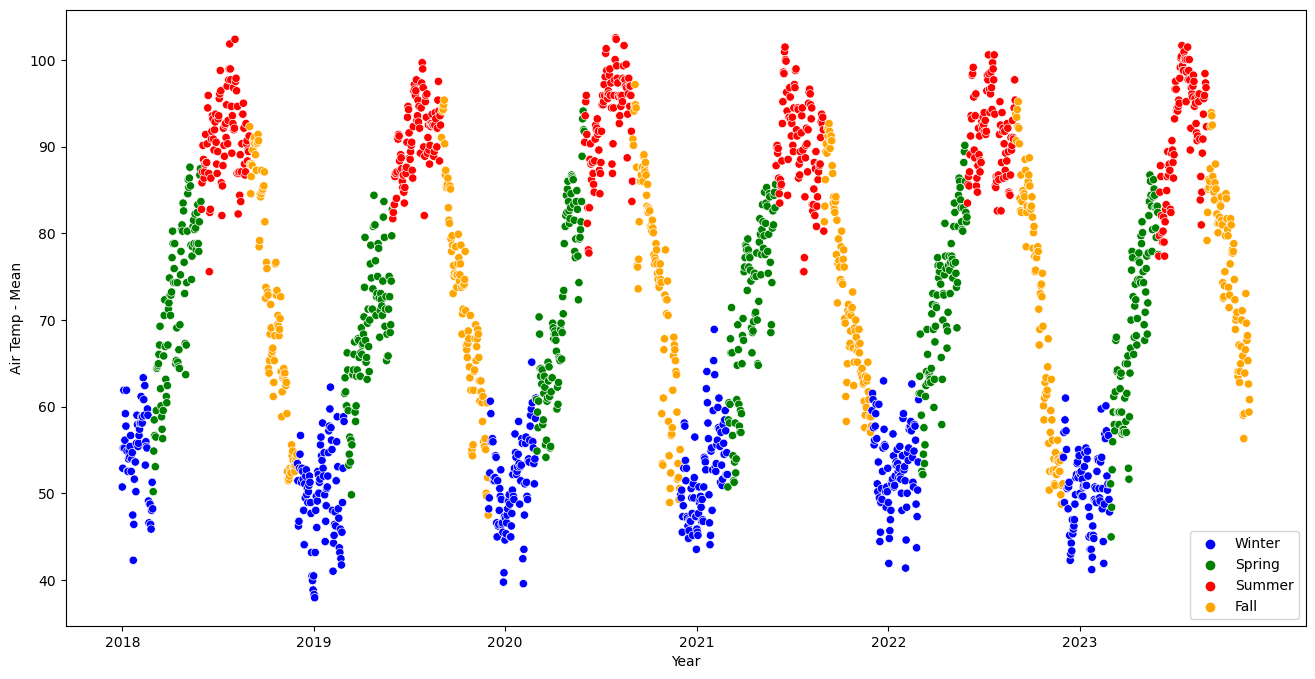

In [22]:
# First lets plot the air temp to make sure our conversion from metric to imperial was correct and to look for any outliers. 
# We will also use season in the hue argument to validate our labeling method.

# Define colors for each season
season_colors = {'Spring': 'green', 'Summer': 'red',
                 'Fall': 'orange', 'Winter': 'blue'}


plt.figure(figsize=(16, 8))
sns.scatterplot(data=df, x=df.index, y='Air Temp - Mean',
                hue='Season', palette=season_colors)
plt.legend(loc='lower right')
# create x ticks by Year
# Get unique years
years = df['Year'].unique()
# Get index of first row of each year, probably overkill since it should always be Day of Year = 1, but just in case.
x_ticks = [df[df['Year'] == year].index[0] for year in years]
plt.xticks(x_ticks, years)  # Set x-ticks to 'Year' column values
plt.xlabel('Year')  # Change x-axis label to 'Year'
plt.show()

Good. We see the expected seasonality of air temperature within the expected range. We can also see that the season labels match what we would expect as each year progresses. We can now begin answering our method questions.

<center>

# Analysis
</center>

In [23]:
# Create a data frame to hold answers to our questions.
df2 = pd.DataFrame(df['Year'].unique(), columns=['Year'])

# Calculate the average summer temperature for each year in 'Year' column
df2['Average Summer Temp'] = df[df['Season'] == 'Summer'].groupby(
    'Year')['Air Temp - Mean'].mean().round(2).values

# Calculate the number of consecutive days above 100 degrees for each year
# Create a Series with all the years
years = pd.Series(range(2018, 2024), name='Year')
# Calculate the count and reindex
counts = df[(df['Air Temp - Mean'] > 100) & (df['Season'] == 'Summer')]['Air Temp - Mean'].groupby(
    df['Year']).count().reindex(years, fill_value=0)  # Fill missing years with 0
# Add the counts to the data frame
df2['Number of Days Above 100'] = counts.values

# Get number of days between first 80 degree day and last 80 degree day for each year.

for year in years:
    # Get the first 80 degree day of the year
    first = df[(df['Air Temp - Mean'] >= 80) &
               (df['Year'] == year)]['Day of Year (DOY)'].min()
    # Get the last 80 degree day of the year
    last = df[(df['Air Temp - Mean'] >= 80) &
              (df['Year'] == year)]['Day of Year (DOY)'].max()
    # Calculate the difference
    diff = last - first
    # Add the difference to the data frame
    df2.loc[df2['Year'] == year,
            'Number of Days Between First and Last 80 Degree Day'] = diff

# Change Number of Days Between First and Last 80 Degree Day to integer
df2['Number of Days Between First and Last 80 Degree Day'] = df2[
    'Number of Days Between First and Last 80 Degree Day'].astype(int)

# Look at the results
df2

,Year,Average Summer Temp,Number of Days Above 100,Number of Days Between First and Last 80 Degree Day
0,2018,90.87,2,176
1,2019,90.82,0,147
2,2020,93.21,6,169
3,2021,90.37,3,156
4,2022,91.29,2,170
5,2023,91.84,10,170


In [24]:
# Let's rank the years by average summer temperature to answer our first metric.
print(df2[['Year', 'Average Summer Temp']].sort_values(
    'Average Summer Temp', ascending=False).to_string(index=False))

 Year  Average Summer Temp
 2020                93.21
 2023                91.84
 2022                91.29
 2018                90.87
 2019                90.82
 2021                90.37


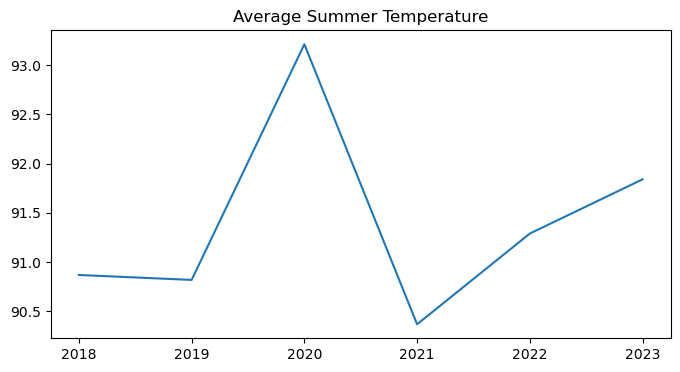

In [25]:
# According to this metric, 2023 wasn't the hottest summer, but it was the second hottest. We have to go back three years to find a hotter summer.
# Let's plot the average summer temperature to get a visual representation.
plt.figure(figsize=(8, 4))
plt.title('Average Summer Temperature')
plt.plot(df2['Year'], df2['Average Summer Temp'])
plt.show()

In [26]:
# Let's rank the years by number of days above 100 degrees to answer our second metric.
print(df2[['Year', 'Number of Days Above 100']].sort_values(
    'Number of Days Above 100', ascending=False).to_string(index=False))

 Year  Number of Days Above 100
 2023                        10
 2020                         6
 2021                         3
 2018                         2
 2022                         2
 2019                         0


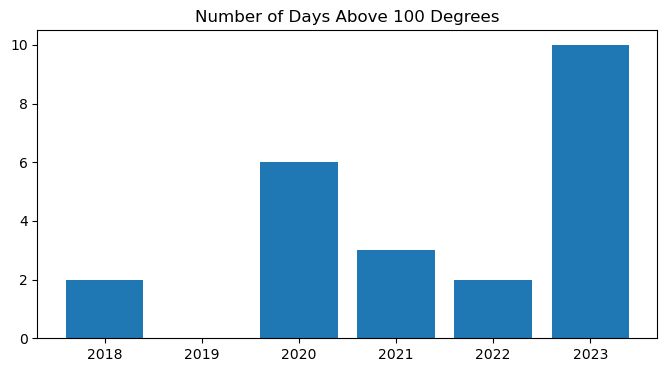

In [27]:
# 2023 had the most days above 100 degrees by a wide margin.
# Let's plot the number of days above 100 degrees to get a visual representation.
plt.figure(figsize=(8, 4))
plt.title("Number of Days Above 100 Degrees")
plt.bar(df2['Year'], df2['Number of Days Above 100'])
plt.show()

In [28]:
# Let's rank the years by number of days between first and last 80 degree day to answer our third metric.
print(df2[['Year', 'Number of Days Between First and Last 80 Degree Day']].sort_values(
    'Number of Days Between First and Last 80 Degree Day', ascending=False).to_string(index=False))

 Year  Number of Days Between First and Last 80 Degree Day
 2018                                                  176
 2022                                                  170
 2023                                                  170
 2020                                                  169
 2021                                                  156
 2019                                                  147


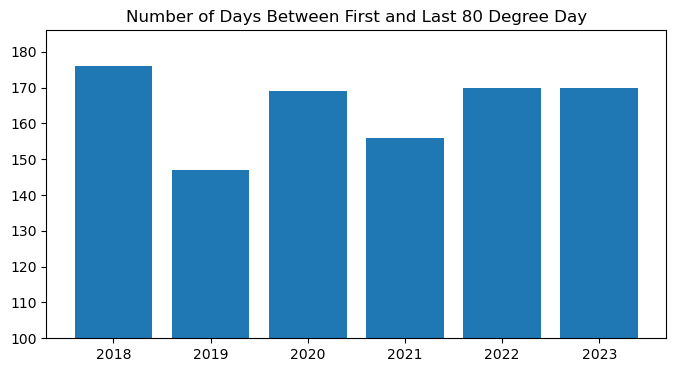

In [29]:
# This year comes in tied for second place with last year in terms of perceived length of summer.
# The only year that scores higher is all the way back in 2018.
# Let's plot for visual representation.
plt.figure(figsize=(8, 4))
plt.title('Number of Days Between First and Last 80 Degree Day')
plt.bar(df2['Year'], df2['Number of Days Between First and Last 80 Degree Day'])
# Set y-axis limits to 100 and max value + 10
plt.ylim([100, max(df2['Number of Days Between First and Last 80 Degree Day']) + 10])
plt.show()

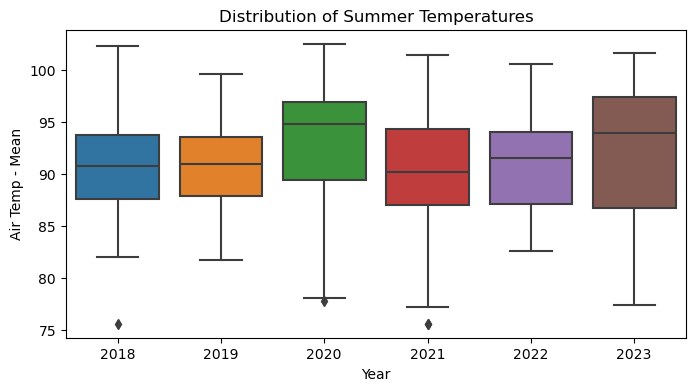

In [30]:
# For good measure, let's use an out of the box solution to plot the distribution of summer temperatures for each year.
plt.figure(figsize=(8, 4))
plt.title('Distribution of Summer Temperatures')
sns.boxplot(data=df[df['Season'] == 'Summer'], x='Year', y='Air Temp - Mean')
plt.show()

<center>

# Conclusion
</center>

1. In terms of average summer temperature, this summer comes in as the second hottest over the last six years, and significantly hotter than the previous two years. This is inline with my perception that this summer was hotter than recent summers past.<br>
2. This summer is the clear winner in terms of days above 100&deg;F, with 2020 being the runner up. This again supports my perception of this summer's comparative intensity.<br>
3. Although tied for second place in terms of perceived summer length, we have to go back to 2018 to find a year that had a longer streak between its first and last 80&deg;F day. This also supports my perception that this summer seemed to drag on for longer than usual (though, I must admit the margins are much thinner than I expected). <br>
4. Examining the box plot, we can see the upper quartile for 2023 is pushed far above previous years, with only 2020 coming close. This proves that 2023's high scores are not due to just a few high outliers, but generally true across the whole summer.<br>

According to the metrics outlined, summer 2023 proves to be a hotter more sustained summer compared to recent years past, particularly over the last three summers. I am now ready to make my case to my friend. 